Load the one-hot encoding and the mix  
Create a model that takes the mix as input and outputs the one-hot encoding  
Train the model  
Save the model  
Load the model  
Test the model  
Save the test results  
Load the test results  
Plot  

In [44]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import librosa
from tqdm import tqdm
from sklearn.utils import class_weight

In [132]:
# Example encoding of a label [1, 1, 0, 1, 0, 0]

irmas_labels = ["cel", "cla", "flu", "gac", "sax", "tru", "vio"]

# Define the labels 
# cello, clarinet, flute, acoustic guitar, electric guitar, organ, piano, saxophone, trumpet, violin, and human singing voice
label_names = ["cello", "clarinet", "flute", "guitar", "saxophone", "trumpet", "violin"]
n_classes = len(label_names)


In [103]:
import pathlib

# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
# data_dir = pathlib.Path(data_dir).with_suffix('')
irmas_labels = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]
label_names = irmas_labels
n_classes = len(label_names)


In [133]:
# Load the data
data_dir = "datasets/IRMAS-TrainingData-images"
# data_dir = "/Users/mariapolak/.keras/datasets/flower_photos_extracted/flower_photos"
image_size = (128, 128)
batch_size = 32

train_ds, test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    validation_split=0.2,
    subset = 'both',
    seed = 123,
    class_names=irmas_labels
)

# Get the class weights
all_labels = []
outputs = np.concatenate([i for x, i in train_ds], axis=0)
for y in outputs:
    all_labels.append(label_names[np.argmax(y)])
all_labels = np.array(all_labels)


class_weights = class_weight.compute_class_weight(class_weight='balanced',                                                  
                                                    classes=np.unique(all_labels),                                                 
                                                    y=all_labels)

# change the format of the class weights to a dictionary
class_weights = {i: class_weights[i] for i in range(n_classes)} 

print(f"Generated class weights for an imbalanced dataset: {class_weights}")

Found 3764 files belonging to 7 classes.
Using 3012 files for training.
Using 752 files for validation.
Generated class weights for an imbalanced dataset: {0: 1.3880184331797234, 1: 1.0677064870613258, 2: 1.1660859465737514, 3: 0.8322741088698535, 4: 0.8675115207373272, 5: 0.9519595448798989, 6: 0.9253456221198156}


2024-11-30 12:58:00.430004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Classes: ['cel', 'cla', 'flu', 'gac', 'sax', 'tru', 'vio']


2024-11-30 12:58:05.149430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


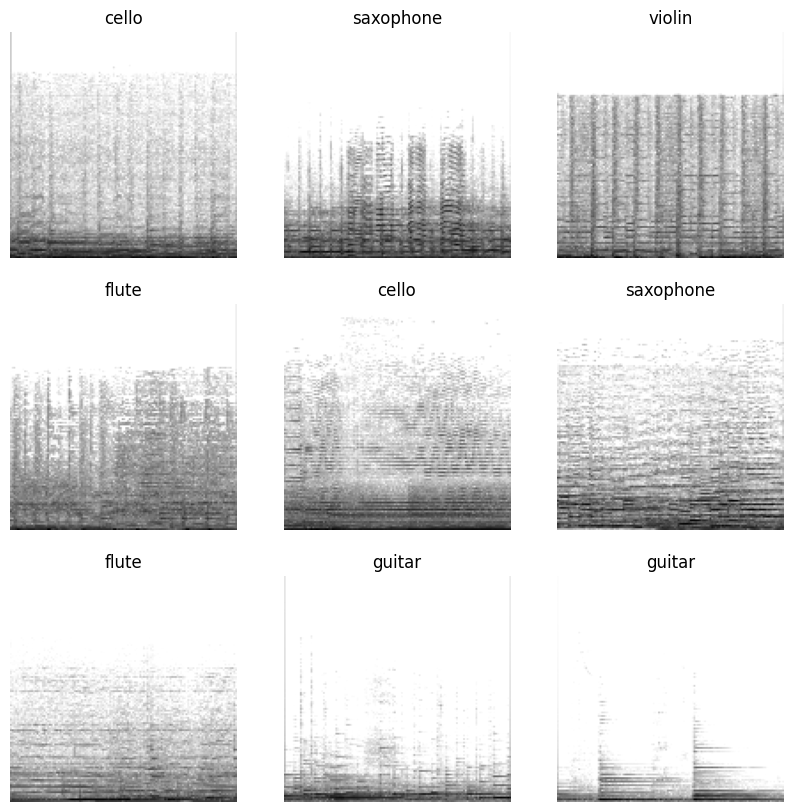

In [134]:
print(f"Classes: {train_ds.class_names}")

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(label_names[np.argmax(labels[i])])
    plt.axis("off")
plt.show()


In [118]:
print(f"Training data size (batches): {train_ds.cardinality()}")
print(f"Testing data size (batches): {test_ds.cardinality()}")


Training data size (batches): 104
Testing data size (batches): 12


In [135]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [136]:
def add_conv_block(model, num_filters=32, dropout_rate=0.25):
    model.add(keras.layers.Conv2D(num_filters, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(keras.layers.Conv2D(num_filters, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(dropout_rate))

In [ ]:
# model = keras.Sequential()
# model.add(keras.Input(shape=(image_size[0], image_size[1], 1)))

# # Preprocessing
# model.add(keras.layers.Rescaling(1./255))

# # Convolution Blocks
# add_conv_block(model, num_filters=32, dropout_rate=0.1)
# add_conv_block(model, num_filters=64, dropout_rate=0.2)
# add_conv_block(model, num_filters=128, dropout_rate=0.3)
# add_conv_block(model, num_filters=256, dropout_rate=0.5)
# model.add(keras.layers.Flatten())

# # Dense Layers
# model.add(keras.layers.Dense(512))
# model.add(keras.layers.Dropout(0.75))
# model.add(keras.layers.Dense(n_classes, activation='softmax'))

# model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_18 (Rescaling)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_147 (Conv2D)             │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_148 (Conv2D)             │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_75 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_149 (Conv2D)             │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_150 (Conv2D)             │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_76 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_91 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_151 (Conv2D)             │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_152 (Conv2D)             │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_77 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_92 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_153 (Conv2D)             │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_154 (Conv2D)             │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_78 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_93 (Dropout)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_94 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,564,391 (36.49 MB)

 Trainable params: 9,564,391 (36.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_simple = keras.Sequential()
model_simple.add(keras.Input(shape=(image_size[0], image_size[1], 1)))

# Preprocessing
model_simple.add(keras.layers.Rescaling(1./255))

# Dense Layers
model_simple.add(keras.layers.Conv2D(16,3, padding='same', activation='relu'))
model_simple.add(keras.layers.MaxPooling2D())
model_simple.add(keras.layers.Conv2D(32,3, padding='same', activation='relu'))
model_simple.add(keras.layers.MaxPooling2D())
model_simple.add(keras.layers.Conv2D(64,3, padding='same', activation='relu'))
model_simple.add(keras.layers.MaxPooling2D())
model_simple.add(keras.layers.Dropout(0.2))
model_simple.add(keras.layers.Flatten())
model_simple.add(keras.layers.Dense(128, activation='relu'))
model_simple.add(keras.layers.Dense(n_classes, activation='softmax'))

model_simple.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

model_simple.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_19 (Rescaling)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_155 (Conv2D)             │ (None, 128, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_79 (MaxPooling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_156 (Conv2D)             │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_80 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_157 (Conv2D)             │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_81 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,121,479 (8.09 MB)

 Trainable params: 2,121,479 (8.09 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
for batch in train_ds.take(1).as_numpy_iterator():
    imgs, labels = batch
    out = model.predict(imgs)
    print(out.shape)
    for i in range(5):
        print(f"Output: {out[i]} | Max Idx: {np.argmax(out[i])} | Class Name: {label_names[np.argmax(out[i])]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
(32, 7)
Output: [2.6452583e-03 4.4234902e-01 3.1321023e-02 1.5965708e-02 1.3773714e-04
 5.0589019e-01 1.6911463e-03] | Max Idx: 5 | Class Name: trumpet
Output: [1.5054760e-03 5.3793681e-01 4.3666761e-02 2.2030896e-02 8.1911436e-05
 3.9306402e-01 1.7140809e-03] | Max Idx: 1 | Class Name: clarinet
Output: [2.7091450e-03 4.4349566e-01 2.9383423e-02 1.4839220e-02 8.2987041e-05
 5.0864166e-01 8.4793859e-04] | Max Idx: 5 | Class Name: trumpet
Output: [4.02264716e-03 4.33851570e-01 2.63328496e-02 1.40049765e-02
 4.81156312e-05 5.20990431e-01 7.49364146e-04] | Max Idx: 5 | Class Name: trumpet
Output: [4.1883639e-03 4.0947741e-01 3.9957475e-02 2.3270974e-02 1.3910609e-04
 5.2166033e-01 1.3063852e-03] | Max Idx: 5 | Class Name: trumpet


2024-11-30 11:01:56.060506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [139]:
history_simple = model_simple.fit(train_ds, validation_data=test_ds, epochs=10, class_weight=class_weights)

Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.1479 - loss: 1.9674 - val_accuracy: 0.1649 - val_loss: 1.9441
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.2139 - loss: 1.9205 - val_accuracy: 0.2992 - val_loss: 1.7904
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.3027 - loss: 1.7650 - val_accuracy: 0.3404 - val_loss: 1.7258
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.3691 - loss: 1.6831 - val_accuracy: 0.3830 - val_loss: 1.6247
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.4464 - loss: 1.4934 - val_accuracy: 0.4309 - val_loss: 1.5388
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.4842 - loss: 1.3983 - val_accuracy: 0.4654 - val_loss: 1.4662
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.5414 - loss: 1.2597 - val_accuracy: 0.4109 - val_loss: 1.5996
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.5782 - loss: 1.1466 - val_accuracy: 0.4521 - 

### Plotting

In [140]:
# plot history of training
def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

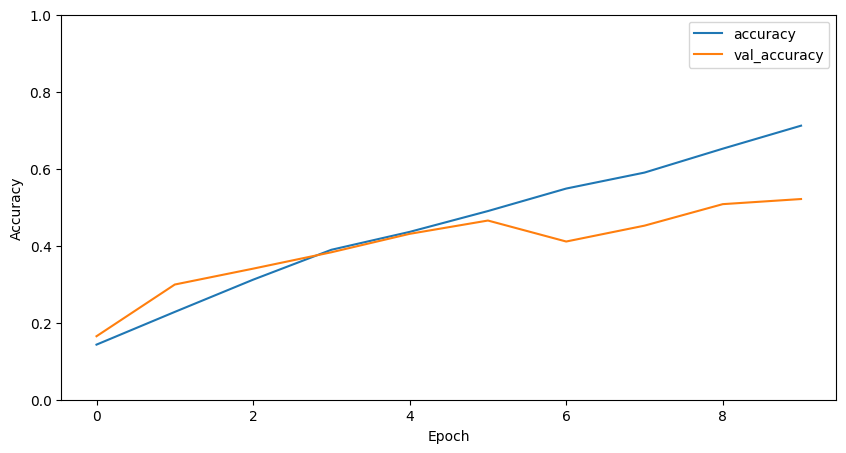

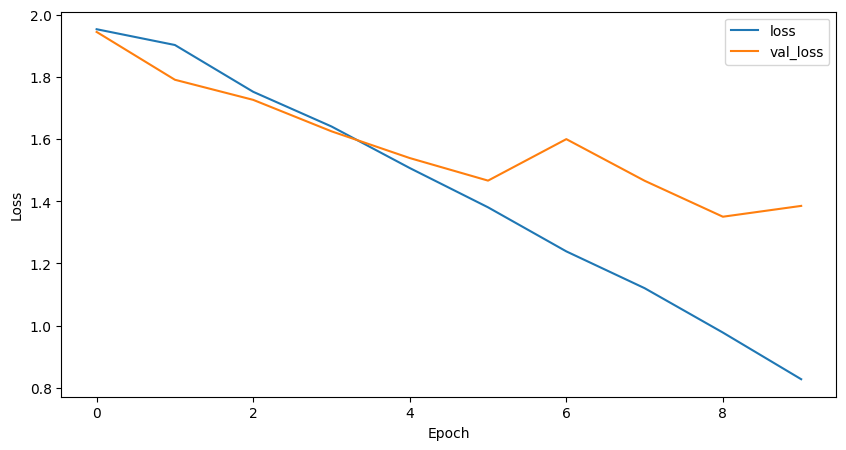

In [141]:
plot_history(history_simple)

In [ ]:
# Save the model
model.save("models/instrument-recognition-2.keras")


In [147]:
# Load the model
model_loaded = keras.models.load_model("models/instrument-recognition-2.keras")
model_loaded.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_19 (Rescaling)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_155 (Conv2D)             │ (None, 128, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_79 (MaxPooling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_156 (Conv2D)             │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_80 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_157 (Conv2D)             │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_81 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,364,439 (24.28 MB)

 Trainable params: 2,121,479 (8.09 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,242,960 (16.19 MB)

In [148]:
model_loaded.evaluate(test_ds)


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5477 - loss: 1.2967


[1.3850136995315552, 0.521276593208313]